## 1. Load and Explore Data

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay




In [93]:
df = pd.read_csv('data/2024_LoL_esports_match_data_from_OraclesElixir1.csv', sep=';')

print(f"Shape: {df.shape}")
print(f"\nAvailable columns: {len(df.columns)}")
df.head()

Shape: (12276, 123)

Available columns: 123


,gameid,datacompleteness,url,league,year,split,playoffs,date,game,patch,...,opp_csat15,golddiffat15,xpdiffat15,csdiffat15,killsat15,assistsat15,deathsat15,opp_killsat15,opp_assistsat15,opp_deathsat15
0,10660-10660_game_1,partial,https://lpl.qq.com/es/stats.shtml?bmid=10660,DCup,2023,NaN,0,01/01/2024 05:13,1,13.24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10660-10660_game_1,partial,https://lpl.qq.com/es/stats.shtml?bmid=10660,DCup,2023,NaN,0,01/01/2024 05:13,1,13.24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10660-10660_game_1,partial,https://lpl.qq.com/es/stats.shtml?bmid=10660,DCup,2023,NaN,0,01/01/2024 05:13,1,13.24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10660-10660_game_1,partial,https://lpl.qq.com/es/stats.shtml?bmid=10660,DCup,2023,NaN,0,01/01/2024 05:13,1,13.24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10660-10660_game_1,partial,https://lpl.qq.com/es/stats.shtml?bmid=10660,DCup,2023,NaN,0,01/01/2024 05:13,1,13.24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [94]:
print("Unique teams:", df['teamname'].nunique())
print("Unique players:", df['playername'].nunique())
print("Unique champions:", df['champion'].nunique())
print("\nPositions:", df['position'].unique())
print("\nSides:", df['side'].unique())
print("\nResults:", df['result'].value_counts())

Unique teams: 253
Unique players: 1304
Unique champions: 146

Positions: ['top' 'jng' 'mid' 'bot' 'sup' 'team']

Sides: ['Blue' 'Red']

Results: result
0    6138
1    6138
Name: count, dtype: int64


## 2. Prepare Clean Dataset

In [95]:
training_columns = [
    'gameid', 'teamname', 'playername', 'position', 'champion', 'side',
    'kills', 'deaths', 'assists', 'teamkills', 'teamdeaths',
    'dragons', 'opp_dragons', 'elders', 'opp_elders',
    'barons', 'opp_barons', 'towers', 'opp_towers', 'totalgold',
    'result'
]

df_clean = df[training_columns].copy()
df_clean = df_clean.fillna(0)
df_clean['playername'] = df_clean['playername'].astype(str)
df_clean['champion'] = df_clean['champion'].astype(str)

print(f"Clean data: {df_clean.shape}")
df_clean.head()

Clean data: (12276, 21)


,gameid,teamname,playername,position,champion,side,kills,deaths,assists,teamkills,...,dragons,opp_dragons,elders,opp_elders,barons,opp_barons,towers,opp_towers,totalgold,result
0,10660-10660_game_1,LNG Esports,Zika,top,Aatrox,Blue,1,3,1,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11083,0
1,10660-10660_game_1,LNG Esports,Weiwei,jng,Maokai,Blue,0,4,3,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8636,0
2,10660-10660_game_1,LNG Esports,Scout,mid,Orianna,Blue,0,2,0,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10743,0
3,10660-10660_game_1,LNG Esports,GALA,bot,Kalista,Blue,2,4,0,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12224,0
4,10660-10660_game_1,LNG Esports,Mark,sup,Senna,Blue,0,3,3,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7221,0


## 3. Create Historical Features (Pre-Game)

Calculate historical statistics for teams, players, and champions:
- **Team winrate** (% victories per team)
- **Player winrate** (% victories per player)
- **Player KDA** (kills + assists / deaths)
- **Champion winrate** (% victories with each champion)
- **Player-Champion mastery** (% victories per player-champion combination)

In [96]:
team_stats = df_clean.groupby('teamname').agg({
    'result': ['mean']
}).reset_index()
team_stats.columns = ['teamname', 'team_winrate']

print("="*70)
print("TEAM WINRATE (Top 10)")
print("="*70)
print(team_stats.sort_values('team_winrate', ascending=False).head(10))
print(f"\nTotal teams: {len(team_stats)}")

TEAM WINRATE (Top 10)
                         teamname  team_winrate
6    Anorthosis Famagusta Esports           1.0
12                  Atleta Esport           1.0
54                    EGN Esports           1.0
59                       Entropiq           1.0
90                 Geekay Esports           1.0
107         Invictus Gaming Young           1.0
112        Ji Jie Hao (é›†ç»“å·)           1.0
82                    GAM Esports           1.0
116                KaBuM! Academy           1.0
158             Nigma Galaxy Male           1.0

Total teams: 253


In [97]:
player_stats = df_clean.groupby('playername').agg({
    'result': ['mean'],
    'kills': 'mean',
    'deaths': 'mean',
    'assists': 'mean'
}).reset_index()

player_stats.columns = ['playername', 'player_winrate', 
                        'player_avg_kills', 'player_avg_deaths', 'player_avg_assists']

player_stats['player_kda'] = (player_stats['player_avg_kills'] + player_stats['player_avg_assists']) / (player_stats['player_avg_deaths'] + 1)

print("\n" + "="*70)
print("PLAYER WINRATE & KDA (Top 10 with min 10 games)")
print("="*70)
print(player_stats.sort_values('player_winrate', ascending=False)[
    ['playername', 'player_winrate', 'player_kda']
].head(10))
print(f"\nTotal players: {len(player_stats)}")


PLAYER WINRATE & KDA (Top 10 with min 10 games)
     playername  player_winrate  player_kda
1304        zzx             1.0    4.428571
1264      scuro             1.0    6.500000
30      Afroboi             1.0    4.238095
1257      pr1me             1.0    2.960000
1263      scary             1.0    7.500000
1248       neny             1.0    8.000000
1229     koubee             1.0    5.000000
1230      kubYD             1.0    4.750000
1238       many             1.0    3.857143
958      Sn1lle             1.0    5.352941

Total players: 1305


In [98]:
champion_stats = df_clean.groupby('champion').agg({
    'result': ['mean', 'count']
}).reset_index()
champion_stats.columns = ['champion', 'champion_winrate', 'champion_games']

print("\n" + "="*70)
print("CHAMPION WINRATE (Top 10 with min 20 games)")
print("="*70)
print(champion_stats[champion_stats['champion_games'] >= 20].sort_values('champion_winrate', ascending=False).head(10))
print(f"\nTotal champions: {len(champion_stats)}")


CHAMPION WINRATE (Top 10 with min 20 games)
    champion  champion_winrate  champion_games
23    Darius          0.761905              21
49      Jinx          0.666667              27
47     Jayce          0.649123              57
18   Caitlyn          0.617021              47
115  Taliyah          0.608108              74
90      Pyke          0.583333              24
73    Maokai          0.581325             332
79      Nami          0.581197             117
66    Lillia          0.575758              33
102    Senna          0.568528             197

Total champions: 147


In [99]:
player_champion_stats = df_clean.groupby(['playername', 'champion']).agg({
    'result': ['mean', 'count']
}).reset_index()
player_champion_stats.columns = ['playername', 'champion', 'player_champ_winrate', 'player_champ_games']

print("\n" + "="*70)
print("PLAYER-CHAMPION MASTERY (Top 10 with min 5 games)")
print("="*70)
print(player_champion_stats[player_champion_stats['player_champ_games'] >= 5].sort_values('player_champ_winrate', ascending=False).head(10))
print(f"\nTotal combinations: {len(player_champion_stats)}")


PLAYER-CHAMPION MASTERY (Top 10 with min 5 games)
       playername  champion  player_champ_winrate  player_champ_games
52            665        Vi                   1.0                   5
590   BrokenBlade   K'Sante                   1.0                   5
493           Bin   K'Sante                   1.0                   5
3654        Oddie    Maokai                   1.0                   5
3190      MISSING      Nami                   1.0                   5
2369       Iwandy  Nautilus                   1.0                   5
2976      Lehends     Milio                   1.0                   6
5609        Yagao      Azir                   1.0                   5
5592          Xun   Lee Sin                   1.0                   5
6238       shanji   K'Sante                   1.0                   5

Total combinations: 6446


## 4. Merge Historical Features to Dataset

In [100]:
df_features = df_clean.copy()

df_features = df_features.merge(team_stats, on='teamname', how='left')
df_features = df_features.merge(player_stats, on='playername', how='left')
df_features = df_features.merge(champion_stats, on='champion', how='left')
df_features = df_features.merge(player_champion_stats, on=['playername', 'champion'], how='left')

print("="*70)
print("DATASET WITH HISTORICAL FEATURES")
print("="*70)
print(f"Shape: {df_features.shape}")
print(f"\nNew columns added:")
new_cols = ['team_winrate', 'player_winrate', 'player_kda', 'champion_winrate', 'player_champ_winrate']
for col in new_cols:
    print(f"  - {col}")

print("\nExample data with features:")
print(df_features[['playername', 'champion', 'teamname', 'player_winrate', 'player_kda', 'champion_winrate', 'team_winrate', 'result']].head(10))

DATASET WITH HISTORICAL FEATURES
Shape: (12276, 31)

New columns added:
  - team_winrate
  - player_winrate
  - player_kda
  - champion_winrate
  - player_champ_winrate

Example data with features:
  playername      champion     teamname  player_winrate  player_kda  \
0       Zika        Aatrox  LNG Esports        0.411765    1.980000   
1     Weiwei        Maokai  LNG Esports        0.411765    2.241379   
2      Scout       Orianna  LNG Esports        0.411765    2.080645   
3       GALA       Kalista  LNG Esports        0.411765    2.595745   
4       Mark         Senna  LNG Esports        0.400000    2.697674   
5     Xiaoxu        Rumble    Rare Atom        0.200000    1.760870   
6     naiyou          Rell    Rare Atom        0.200000    1.444444   
7      VicLa       LeBlanc    Rare Atom        0.200000    1.660000   
8      Assum         Varus    Rare Atom        0.200000    1.537037   
9      Zorah  Renata Glasc    Rare Atom        0.214286    1.958333   

   champion_winrate 

## 5. Correlation Matrix: Historical Features vs Result

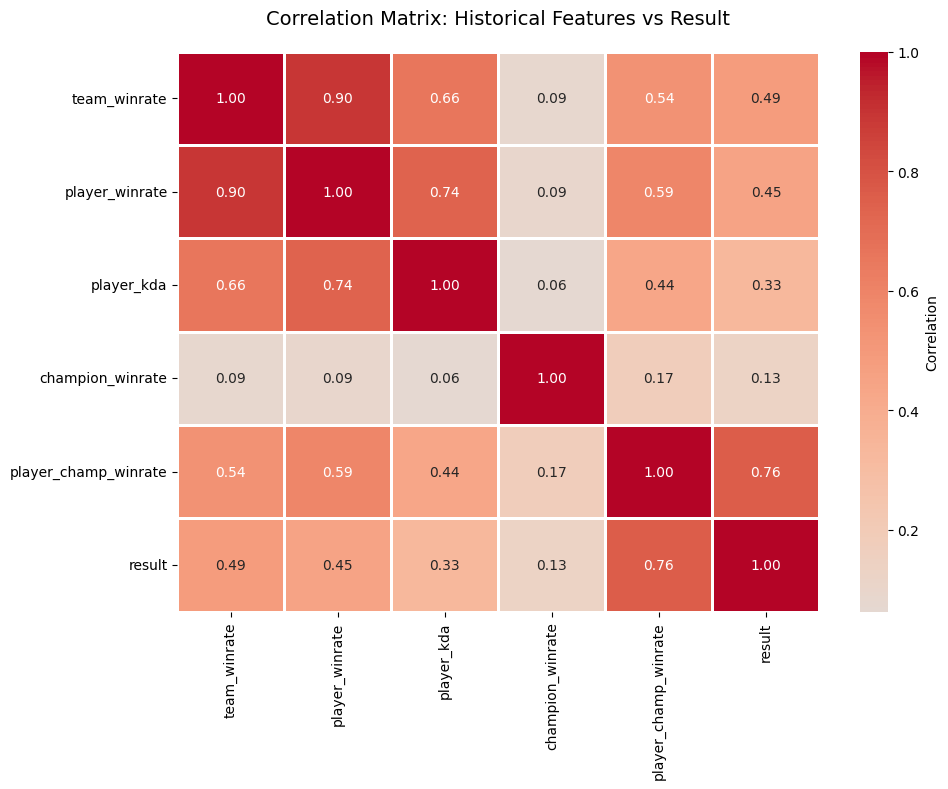


CORRELATION WITH RESULT (sorted by absolute value)
player_champ_winrate          : +0.7591
team_winrate                  : +0.4911
player_winrate                : +0.4499
player_kda                    : +0.3310
champion_winrate              : +0.1316


In [101]:
import seaborn as sns
import matplotlib.pyplot as plt

# Load data

correlation_cols = ['team_winrate', 'player_winrate', 'player_kda', 'champion_winrate', 'player_champ_winrate', 'result']
correlation_matrix = df_features[correlation_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            linewidths=1, cbar_kws={'label': 'Correlation'})
plt.title('Correlation Matrix: Historical Features vs Result', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("CORRELATION WITH RESULT (sorted by absolute value)")
print("="*70)
result_corr = correlation_matrix['result'].drop('result').sort_values(key=abs, ascending=False)
for feature, corr_value in result_corr.items():
    print(f"{feature:30s}: {corr_value:+.4f}")

## 6. Encode Variables & Prepare ML Features

In [102]:
le_team = LabelEncoder()
le_player = LabelEncoder()
le_champion = LabelEncoder()
le_side = LabelEncoder()
le_position = LabelEncoder()

df_ml = df_features.copy()

df_ml['team_encoded'] = le_team.fit_transform(df_clean['teamname'])
df_ml['player_encoded'] = le_player.fit_transform(df_clean['playername'])
df_ml['champion_encoded'] = le_champion.fit_transform(df_clean['champion'])
df_ml['side_encoded'] = le_side.fit_transform(df_clean['side'])
df_ml['position_encoded'] = le_position.fit_transform(df_clean['position'])

print("="*70)
print("ENCODED VARIABLES")
print("="*70)
print(f"  - {len(le_team.classes_)} teams")
print(f"  - {len(le_player.classes_)} players")
print(f"  - {len(le_champion.classes_)} champions")
print(f"  - {len(le_side.classes_)} sides")
print(f"  - {len(le_position.classes_)} positions")

features_pregame = [
    'team_encoded', 'player_encoded', 'champion_encoded', 'side_encoded', 'position_encoded',
    'team_winrate', 'player_winrate', 'player_kda', 'champion_winrate', 'player_champ_winrate'
]

X = df_ml[features_pregame]
y = df_ml['result']

ENCODED VARIABLES
  - 253 teams
  - 1305 players
  - 147 champions
  - 2 sides
  - 6 positions


## Hyper parametes configuration

In [103]:
BATCH_SIZE_TRAIN = 16
BATCH_SIZE_TEST = 1000
PRINT_INTERVAL = 10
LEARNING_RATE = 0.001
EPOCHS = 50
DROPOUT_RATE = 0.2

## 8. Train/Test Split & Scale Numeric Features

In [104]:
import torch
import torch.utils.data as data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Define ALL feature columns (excluding 'result')
all_features = [
    'team_encoded', 'player_encoded', 'champion_encoded', 'side_encoded', 'position_encoded',
    'team_winrate', 'player_winrate', 'player_kda', 'champion_winrate', 'player_champ_winrate',
    'kills', 'deaths', 'assists', 'teamkills', 'teamdeaths',
    'dragons', 'opp_dragons', 'elders', 'opp_elders',
    'barons', 'opp_barons', 'towers', 'opp_towers', 'totalgold'
]

numeric_features_to_scale = ['team_winrate', 'player_winrate', 'player_kda', 'champion_winrate', 'player_champ_winrate', 'kills', 'deaths', 'assists', 'teamkills', 'teamdeaths', 'dragons', 'opp_dragons', 'elders', 'opp_elders', 'barons', 'opp_barons', 'towers', 'opp_towers', 'totalgold']
categorical_features = ['team_encoded', 'player_encoded', 'champion_encoded', 'side_encoded', 'position_encoded']

# Prepare X and y
X = df_ml[all_features]
y = df_ml['result'].values

# Train/test split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale ONLY numeric features
scaler = StandardScaler()
x_train_scaled = x_train.copy()
x_test_scaled = x_test.copy()

x_train_scaled[numeric_features_to_scale] = scaler.fit_transform(x_train[numeric_features_to_scale])
x_test_scaled[numeric_features_to_scale] = scaler.transform(x_test[numeric_features_to_scale])

# Convert to numpy arrays then to PyTorch tensors
x_train_tensor = torch.FloatTensor(x_train_scaled.values)
y_train_tensor = torch.FloatTensor(y_train).unsqueeze(1)
x_test_tensor = torch.FloatTensor(x_test_scaled.values)
y_test_tensor = torch.FloatTensor(y_test).unsqueeze(1)

# Create datasets
train_dataset = data.TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = data.TensorDataset(x_test_tensor, y_test_tensor)

# Create dataloaders
train_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE_TRAIN, shuffle=True)
test_loader = data.DataLoader(test_dataset, batch_size=BATCH_SIZE_TEST, shuffle=False)

print(f"\nTotal features: {len(all_features)}")
print(f"Categorical features (not scaled): {len(categorical_features)}")
print(f"Numeric features (scaled): {len(numeric_features_to_scale)}")
print(f"\nTraining set size: {len(train_dataset)}")
print(f"Test set size: {len(test_dataset)}")
print(f"Training batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")
print(f"\nInput shape: {x_train_tensor.shape}")
print(f"Target shape: {y_train_tensor.shape}")



Total features: 24
Categorical features (not scaled): 5
Numeric features (scaled): 19

Training set size: 9820
Test set size: 2456
Training batches: 614
Test batches: 3

Input shape: torch.Size([9820, 24])
Target shape: torch.Size([9820, 1])


## 10. Train Neural Network

In [105]:
import torch.nn as nn
import torch.nn.functional as F

class AI_LoL_NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 64)  # input → 64
        self.dropout1 = nn.Dropout(DROPOUT_RATE)
        self.fc2 = nn.Linear(64, 32)  # 64 → 32
        self.dropout2 = nn.Dropout(DROPOUT_RATE)
        self.fc3 = nn.Linear(32, 1)    # 32 → 1 (binary classification)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.sigmoid(self.fc3(x)) 
        return x

        # Create model with correct input size
input_size   = len(all_features)
model = AI_LoL_NeuralNetwork(input_size)

print("="*70)
print("NEURAL NETWORK ARCHITECTURE")
print("="*70)
print(f"Input features: {input_size}")
print(f"Architecture: {input_size} → 64 → 32 → 1")
print(f"\n{model}")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"\nTotal parameters: {total_params:,}")


NEURAL NETWORK ARCHITECTURE
Input features: 24
Architecture: 24 → 64 → 32 → 1

AI_LoL_NeuralNetwork(
  (fc1): Linear(in_features=24, out_features=64, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)

Total parameters: 3,713


## 11. Training Visualization

## 10. Training History Visualization

In [106]:
import torch.optim as optim

# Loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy for binary classification
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Training history
train_losses = []
train_accuracies = []

print("="*70)
print("TRAINING NEURAL NETWORK")
print("="*70)

# Training loop
for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        # Forward pass
        output = model(data)
        loss = criterion(output, target)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Statistics
        epoch_loss += loss.item()
        predictions = (output > 0.5).float()
        correct += (predictions == target).sum().item()
        total += target.size(0)
        
        # Print progress
        if batch_idx % PRINT_INTERVAL == 0:
            print(f'Epoch [{epoch+1}/{EPOCHS}], Batch [{batch_idx}/{len(train_loader)}], Loss: {loss.item():.4f}')
    
    # Epoch statistics
    avg_loss = epoch_loss / len(train_loader)
    accuracy = 100 * correct / total
    
    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)
    
    print(f'\n==> Epoch {epoch+1}/{EPOCHS}: Loss = {avg_loss:.4f}, Accuracy = {accuracy:.2f}%\n')

print('='*70)
print('TRAINING COMPLETED!')
print('='*70)

TRAINING NEURAL NETWORK
Epoch [1/50], Batch [0/614], Loss: 2.4152
Epoch [1/50], Batch [10/614], Loss: 2.7419
Epoch [1/50], Batch [20/614], Loss: 4.0382
Epoch [1/50], Batch [30/614], Loss: 5.2226
Epoch [1/50], Batch [40/614], Loss: 3.0096
Epoch [1/50], Batch [50/614], Loss: 1.5609
Epoch [1/50], Batch [60/614], Loss: 10.2031
Epoch [1/50], Batch [70/614], Loss: 2.3995
Epoch [1/50], Batch [80/614], Loss: 2.2820
Epoch [1/50], Batch [90/614], Loss: 1.9607
Epoch [1/50], Batch [100/614], Loss: 1.3528
Epoch [1/50], Batch [110/614], Loss: 0.8765
Epoch [1/50], Batch [120/614], Loss: 1.1617
Epoch [1/50], Batch [90/614], Loss: 1.9607
Epoch [1/50], Batch [100/614], Loss: 1.3528
Epoch [1/50], Batch [110/614], Loss: 0.8765
Epoch [1/50], Batch [120/614], Loss: 1.1617
Epoch [1/50], Batch [130/614], Loss: 0.5990
Epoch [1/50], Batch [140/614], Loss: 0.9404
Epoch [1/50], Batch [150/614], Loss: 0.9295
Epoch [1/50], Batch [160/614], Loss: 0.8340Epoch [1/50], Batch [130/614], Loss: 0.5990
Epoch [1/50], Batch 

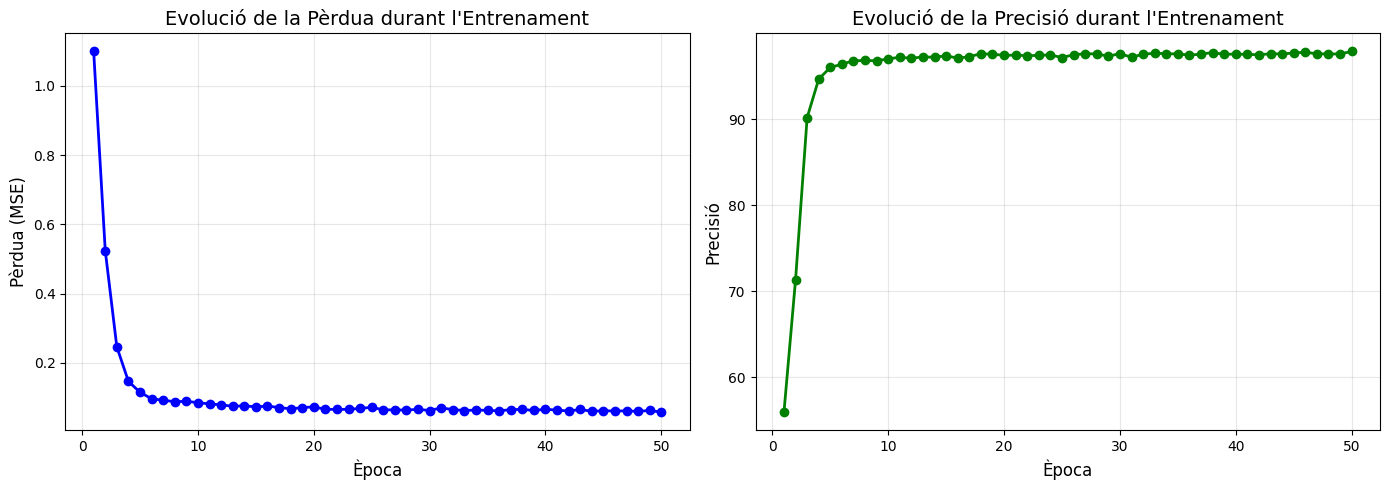

In [107]:
# Visualització de l'evolució
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Gràfic de pèrdua
ax1.plot(range(1, EPOCHS+1), train_losses, 'b-o', linewidth=2)
ax1.set_xlabel('Època', fontsize=12)
ax1.set_ylabel('Pèrdua (MSE)', fontsize=12)
ax1.set_title('Evolució de la Pèrdua durant l\'Entrenament', fontsize=14)
ax1.grid(True, alpha=0.3)

# Gràfic de precisió
ax2.plot(range(1, EPOCHS+1), train_accuracies, 'g-o', linewidth=2)
ax2.set_xlabel('Època', fontsize=12)
ax2.set_ylabel('Precisió', fontsize=12)
ax2.set_title('Evolució de la Precisió durant l\'Entrenament', fontsize=14)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 12. Evaluate Model

In [108]:
from sklearn.metrics import accuracy_score, r2_score


model.eval()
y_pred_list = []
y_test_list = []

with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        y_pred_list.extend(output.cpu().numpy())
        y_test_list.extend(target.cpu().numpy())

y_pred_proba = np.array(y_pred_list)
y_test_array = np.array(y_test_list).flatten()
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

acc_test = accuracy_score(y_test_array, y_pred)
r2 = r2_score(y_test_array, y_pred)
mean = np.mean(y_test_array)
std = np.std(y_test_array)

print("\n" + "="*70)
print("NEURAL NETWORK MODEL RESULTS")
print("="*70)
print(f"Test Accuracy: {acc_test:.2%}")
print(f"R² Score: {r2:.4f}")
print(f"MEAN: {mean:.2f}")
print(f"STD: {std:.2f}")



print("\n" + "="*70)
print("PREDICTION EXAMPLES:")
print("="*70)
for i in range(5):
    prob_vic = y_pred_proba[i][0] * 100
    prob_def = (1 - y_pred_proba[i][0]) * 100
    actual = "Victory" if y_test_array[i] == 1 else "Defeat"
    pred = "Victory" if y_pred[i] == 1 else "Defeat"
    print(f"Actual: {actual:8} | Pred: {pred:8} | Defeat: {prob_def:5.1f}% | Victory: {prob_vic:5.1f}%")



NEURAL NETWORK MODEL RESULTS
Test Accuracy: 97.88%
R² Score: 0.9153
MEAN: 0.51
STD: 0.50

PREDICTION EXAMPLES:
Actual: Victory  | Pred: Victory  | Defeat:   0.0% | Victory: 100.0%
Actual: Victory  | Pred: Victory  | Defeat:   2.7% | Victory:  97.3%
Actual: Victory  | Pred: Victory  | Defeat:   0.0% | Victory: 100.0%
Actual: Defeat   | Pred: Defeat   | Defeat: 100.0% | Victory:   0.0%
Actual: Victory  | Pred: Victory  | Defeat:   0.0% | Victory: 100.0%


## 13. Confusion Matrix

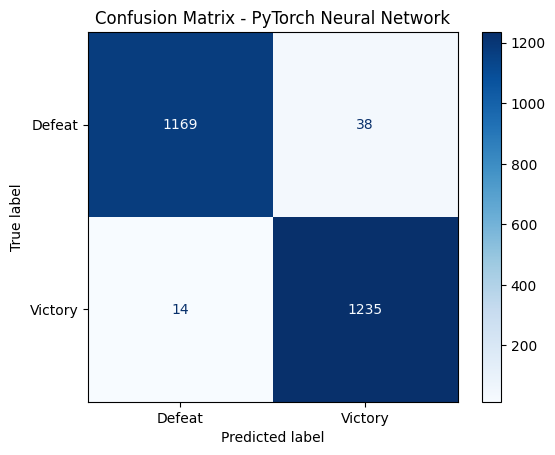


Classification Report:
              precision    recall  f1-score   support

      Defeat       0.99      0.97      0.98      1207
     Victory       0.97      0.99      0.98      1249

    accuracy                           0.98      2456
   macro avg       0.98      0.98      0.98      2456
weighted avg       0.98      0.98      0.98      2456



In [109]:
cm = confusion_matrix(y_test_array, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['Defeat', 'Victory'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - PyTorch Neural Network')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test_array, y_pred, target_names=['Defeat', 'Victory']))